In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import poisson
from typing import Tuple

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (8, 4)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.facecolor'] = 'white'

#### 4.4. Value iteration

> We implement exercise 4.9: **Gambler's problem**

---

The state represents the gambler's capital. The set of states possible states is:
\begin{align}
    s \in \{ 1, 2, \dots , 99  \}
\end{align}

The actions are the amount of capital that is put at stake at a given turn. The set of possible actions depends on the state and is:
\begin{align}
    a \in \{ 0, 1, \dots \min(s, 100-s) \}
\end{align}

The next state $s'$ is determined by $s, a$ and the outcome of a coin flip:
\begin{align}
s' = 
\begin{cases}
s + a \quad \text{if coin is } H \\
s - a \quad \text{if coin is } T
\end{cases}
\end{align}

Since we are given the probabilities of the coin coming up heads and tail, we know that:
\begin{align}
s' = 
\begin{cases}
s + a \quad \text{with probability }  p_h \\
s - a \quad \text{with probability}  (1 - p_h)
\end{cases}
\end{align}

Finally, the gambler receives a reward of +1 when it reaches the goal state of $100$ and zero otherwise.

Now we can implement value iteration to learn the probability of winning from each state.

In [18]:
# Initialize
MAX_SWEEPS = 5
PROB_HEADS = 0.25
GOAL = 100
THETA = 1e-5
states_set = np.arange(GOAL + 1)
reward_set = np.array([0, 1])
values = np.zeros(GOAL + 1)
policy = np.zeros(GOAL + 1)

# We know that the value of s = 100 is +1
values[GOAL] = 1
value_sweeps = []
policy_stable = False
delta = 0
num_sweeps = 0
TERMINATE = False

## Policy evaluation
while num_sweeps < MAX_SWEEPS:
    old_values = values.copy()
    value_sweeps.append(old_values)
    
    print(f'Policy evaluation {num_sweeps}')    
    # Loop over states
    for state in states_set[1:GOAL]:

        # Create action set based on state
        action_set = np.arange(min(state, GOAL - state) + 1)

        # Update state value with maximum
        values[state] = np.max([
            PROB_HEADS * values[state + action] + (1 - PROB_HEADS) * values[state - action] for action in action_set
        ])
        # Update delta
        delta = max(delta, abs(old_values[state] - values[state]))

    num_sweeps += 1
    
    if delta < THETA:
        # Keep track of values over sweeps
        value_sweeps.append(old_values.copy())
        break
   
print(f'Start policy improvement')
## Policy improvement
# Output a deterministic policy 
for state in states_set[1:GOAL]:
    action_set = np.arange(min(state, GOAL - state) + 1)

    # Update state value with maximum
    expected_returns = [
        PROB_HEADS * values[state + action] + (1 - PROB_HEADS) * values[state - action] for action in action_set
    ]
    # Update delta
    delta = max(delta, abs(old_values[state] - values[state]))

    #TODO: how to do policy improvement with a variable action set
    # Take action associated with maximum expected value (exluding the zero action)
    policy[state] = action_set[np.argmax(np.array(expected_returns))]

Policy evaluation 0
Policy evaluation 1
Policy evaluation 2
Policy evaluation 3
Policy evaluation 4
Start policy improvement


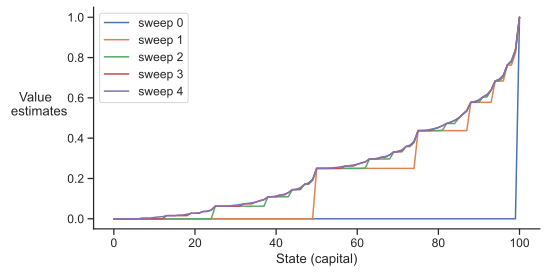

In [16]:
plt.title('')
for sweep_idx, values in enumerate(value_sweeps): plt.plot(values, label=f'sweep {sweep_idx}')
plt.xlabel('State (capital)')
plt.ylabel('Value \n estimates', rotation=0, labelpad=30)
plt.legend()
sns.despine()